In [1]:
import os, sys
sys.path.append("/content")
from src.utils import fit_mlp, plot_obs_predict

with open("/content/credentials") as f:
    env_vars = f.read().split("\n")

for var in env_vars:
    key, value = var.split(" = ")
    os.environ[key] = value

storage_options = {"account_name":os.environ["ACCOUNT_NAME"],
                   "account_key":os.environ["BLOB_KEY"]}

In [2]:
# Specify hyperparameters and fit model
buffer_distance = 500
day_tolerance = 8
cloud_thr = 80
min_water_pixels = 10
features = [
    "Intercept", "sentinel-2-l2a_AOT", "sentinel-2-l2a_B02",
    "sentinel-2-l2a_B03", "sentinel-2-l2a_B04", "sentinel-2-l2a_B08",
    "sentinel-2-l2a_WVP", "sentinel-2-l2a_B05", "sentinel-2-l2a_B06",
    "sentinel-2-l2a_B07", "sentinel-2-l2a_B8A", 
    "is_brazil", "sine_julian", "sentinel-2-l2a_B11",
    "mean_viewing_azimuth", "mean_viewing_zenith",
    "mean_solar_azimuth", "mean_solar_zenith"
]
epochs = 500
batch_size = 64
learning_rate = 0.01

model_out = fit_mlp(
    buffer_distance,
    day_tolerance,
    cloud_thr,
    min_water_pixels,
    features,
    learning_rate,
    batch_size,
    epochs,
    storage_options
)

Begin training.
Epoch 10/500 | Train Loss: 1.48739 | Val Loss: 1.56406
Epoch 20/500 | Train Loss: 1.20332 | Val Loss: 1.36997
Epoch 30/500 | Train Loss: 1.11608 | Val Loss: 1.51790
Epoch 40/500 | Train Loss: 1.12582 | Val Loss: 1.52720
Epoch 50/500 | Train Loss: 1.20589 | Val Loss: 1.47914
Epoch 60/500 | Train Loss: 1.05487 | Val Loss: 1.41806
Epoch 70/500 | Train Loss: 1.07340 | Val Loss: 1.25302
Epoch 80/500 | Train Loss: 0.99248 | Val Loss: 1.25828
Epoch 90/500 | Train Loss: 1.01738 | Val Loss: 1.25206
Epoch 100/500 | Train Loss: 1.03541 | Val Loss: 1.22850
Epoch 110/500 | Train Loss: 0.97681 | Val Loss: 1.25369
Epoch 120/500 | Train Loss: 0.95744 | Val Loss: 1.22727
Epoch 130/500 | Train Loss: 1.00512 | Val Loss: 1.18545
Epoch 140/500 | Train Loss: 0.91103 | Val Loss: 1.20179
Epoch 150/500 | Train Loss: 0.91118 | Val Loss: 1.18685
Epoch 160/500 | Train Loss: 0.88534 | Val Loss: 1.16276
Epoch 170/500 | Train Loss: 1.00501 | Val Loss: 1.19509
Epoch 180/500 | Train Loss: 0.94708 | Val

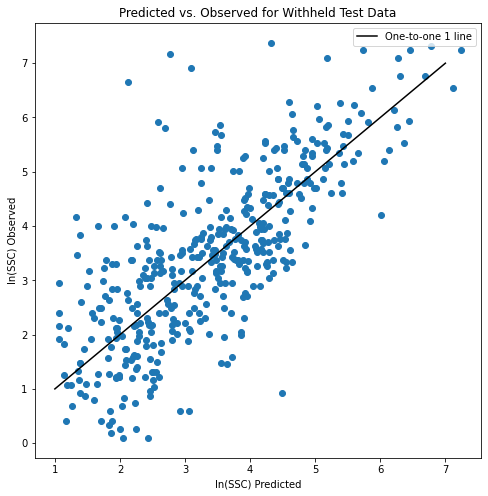

In [3]:
# Plot observed vs predicted for Test data
plot_obs_predict(
    model_out["test_obs_predict"], 
    title="Predicted vs. Observed for Withheld Test Data",
    savefig=False)

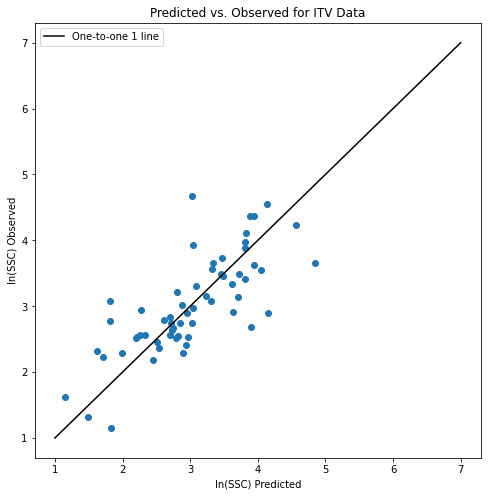

In [5]:
# Plot observed vs predicted for ITV data
plot_obs_predict(
    model_out["itv_obs_predict"], 
    title="Predicted vs. Observed for ITV Data",
    savefig=False)